# Determining tortuosity using geometric domain decomposition

Import necessary packages and functions

In [1]:
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
ps.visualization.set_mpl_style()

## Generate test image

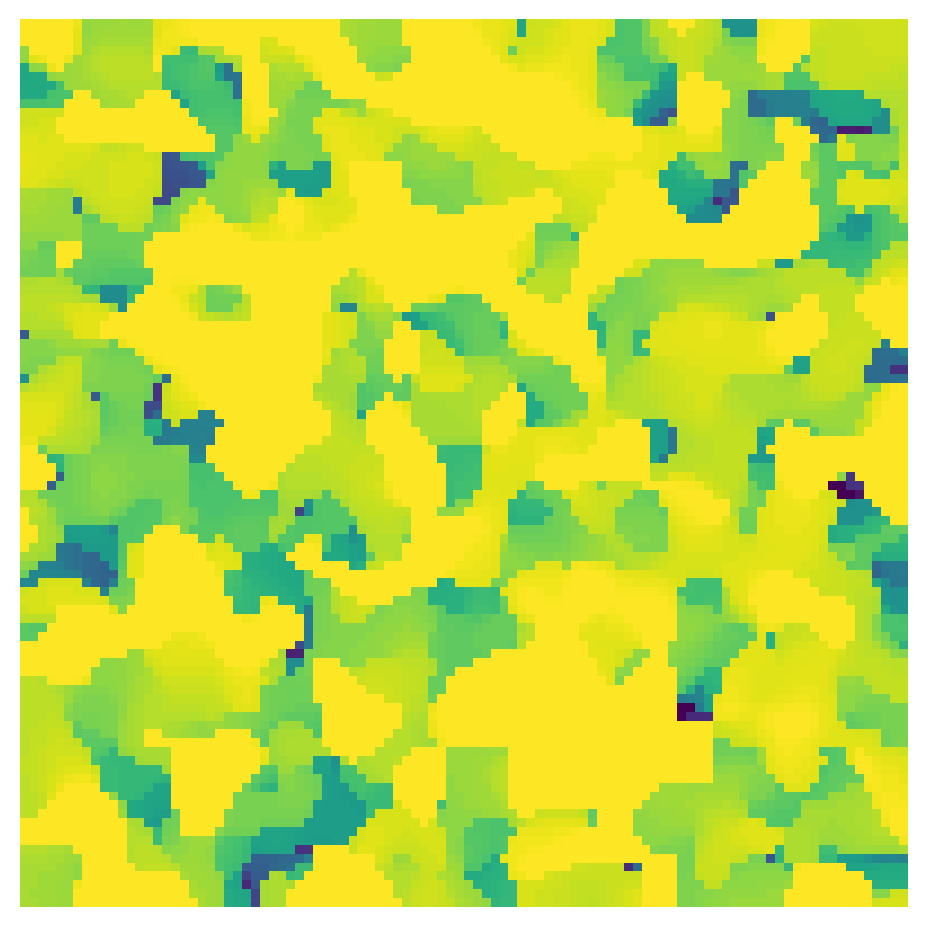

In [2]:
# im = ps.generators.fractal_noise(shape=[100,100,100], seed=1)<0.8
np.random.seed(1)
im = ps.generators.blobs(shape=[100, 100, 100], porosity=0.7)
plt.imshow(ps.visualization.sem(~im))
plt.axis('off');

## Run the function on the image

In [6]:
from porespy.beta import tortuosity_bt
out = tortuosity_bt(im, block_size=50)
print(out)

[22:18:34] WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

[22:18:38] ERROR    Inlet/outlet rates don't match: 2.2810e+01 vs. -2.2802e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.1896e+01 vs. -2.1890e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.6630e+01 vs. -2.6619e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.4781e+01 vs. -2.4769e+01                          _dns.py:109

[22:18:39] WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           ERROR    Inlet/outlet rates don't match: 2.5437e+01 vs. -2.5431e+01                          _dns.py:109

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           ERROR    Inlet/outlet rates don't match: 2.7020e+01 vs. -2.7012e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.3387e+01 vs. -2.3378e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.5927e+01 vs. -2.5921e+01                          _dns.py:109

[22:18:41] ERROR    Inlet/outlet rates don't match: 2.6571e+01 vs. -2.6564e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.5440e+01 vs. -2.5433e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.5395e+01 vs. -2.5391e+01                          _dns.py:109

[22:18:42] ERROR    Inlet/outlet rates don't match: 2.8140e+01 vs. -2.8126e+01                          _dns.py:109

[1.3925109029722786, 1.3999150512069598, 1.3606684244878253]


The three values in the returned list are the tortuosity values in the x, y, and z-direction respectively. However, there is a more useful form of this function.

In [10]:
from porespy.beta import analyze_blocks
out2 = analyze_blocks(im, block_size=50)
out2.iloc[:10,:]

[22:19:51] WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

[22:19:56] ERROR    Inlet/outlet rates don't match: 2.1896e+01 vs. -2.1890e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.3387e+01 vs. -2.3378e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.7020e+01 vs. -2.7012e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.6571e+01 vs. -2.6564e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.5927e+01 vs. -2.5921e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.6630e+01 vs. -2.6619e+01                          _dns.py:109

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           ERROR    Inlet/outlet rates don't match: 2.5440e+01 vs. -2.5433e+01                          _dns.py:109

           WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

           ERROR    Inlet/outlet rates don't match: 2.8140e+01 vs. -2.8126e+01                          _dns.py:109

[22:19:58] ERROR    Inlet/outlet rates don't match: 2.2810e+01 vs. -2.2802e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.5437e+01 vs. -2.5431e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.4781e+01 vs. -2.4769e+01                          _dns.py:109

           ERROR    Inlet/outlet rates don't match: 2.5395e+01 vs. -2.5391e+01                          _dns.py:109

,eps_orig,eps_perc,g,tau,volume,length,axis,time
0,0.705176,0.705176,25.439633,1.414264,125000,50.0,0,4.177472
1,0.721312,0.721312,26.571451,1.385007,125000,50.0,0,3.947818
2,0.705616,0.705592,26.630394,1.351823,125000,50.0,0,4.038600
3,0.651352,0.651344,21.896334,1.517690,125000,50.0,0,3.931128
4,0.706072,0.706024,25.394748,1.418468,125000,50.0,1,2.053686
5,0.717600,0.717600,27.020315,1.354990,125000,50.0,1,3.961196
6,0.691104,0.691016,24.780591,1.422723,125000,50.0,1,2.012183
7,0.679584,0.679256,22.810414,1.519303,125000,50.0,1,1.946066
8,0.695480,0.695480,25.926987,1.368600,125000,50.0,2,4.006884
9,0.683104,0.683104,23.386926,1.490245,125000,50.0,2,3.937272


The ``analyze_blocks`` function returns a `DataFrame` containing the tortuosity, diffusive conductance, and porosity values of each block, which can be used to obtain the tortuosity by using OpenPNM to solve the resistor network as follows.  Start by assigning the diffusive conductance values to the network, then run the simulation:

In [13]:
net = op.network.Cubic([2, 2, 2])
air = op.phase.Phase(network=net)

air['throat.diffusive_conductance']=np.array(out2.iloc[:,2]).flatten()

fd = op.algorithms.FickianDiffusion(network=net, phase=air)
fd.set_value_BC(pores=net.pores('left'), values=1)
fd.set_value_BC(pores=net.pores('right'), values=0)
fd.run()

rate_inlet = fd.rate(pores=net.pores('left'))[0]

# the length of one block is removed from the total length since the network edge begins
# in the center of the first slice and ends in the center of the last slice, so the image
# length is decreased
L = im.shape[1] - 50
A = im.shape[0] * im.shape[2]
d_eff = rate_inlet * L /(A * (1-0))

e = im.sum() / im.size
D_AB = 1

tau_gdd = e * D_AB / d_eff

tau_gdd


1.3606684244878253

The direct calculation can also be done on the same image, and the results can be compared. 

In [14]:
direct = ps.simulations.tortuosity_fd(im, 0)
tau_direct = direct.tortuosity
tau_direct

[22:22:49] WARNING  Found non-percolating regions, were filled to percolate                              _dns.py:74

1.4041847226215034

With similar results, the main benefit to using the "block and tackle" method is the time save on larger images. 